In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
import numpy as np
import os
import time

import importlib

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# The Black Scholes Formula
The Black–Scholes formula calculates the price of European put and call options. This price is consistent with the Black–Scholes equation. This follows since the formula can be obtained by solving the equation for the corresponding terminal and boundary conditions:
$$    

    {\begin{aligned}&C(0,t)=0{\text{ for all }}t\\&C(S,t)\rightarrow S-K{\text{ as }}S\rightarrow \infty \\&C(S,T)=\max\{S-K,0\}\end{aligned}}

    $$

The value of a call option for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

$$
    {\begin{aligned}C(S_{t},t)&=N(d_{+})S_{t}-N(d_{-})Ke^{-r(T-t)}\\d_{+}&={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\d_{-}&=d_{+}-\sigma {\sqrt {T-t}}\\\end{aligned}}
    $$

The price of a corresponding put option based on put–call parity with discount factor $e^{{-r(T-t)}}$ is:
$$
    {\begin{aligned}P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t)\\&=N(-d_{-})Ke^{-r(T-t)}-N(-d_{+})S_{t}\end{aligned}}\,
    $$

In [3]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t
d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)
N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5)))
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Option Price:", C.item()) #17.01496

Option Price: 17.01496124267578


# The Black Scholes Equation
The gradient is calculated using the auto gradient method in pytorch.

$$
{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0
$$

To check the correctness of the calculation, it uses the Greeks equation from the Black-Scholes Formula.

In [4]:
dCdt, = tgrad.grad(C, t, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
dCdS, = tgrad.grad(C, S, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
d2CdS2, = tgrad.grad(dCdS, S, grad_outputs=torch.ones(dCdS.shape), create_graph=True, only_inputs=True)
dCdvol, = tgrad.grad(C, sigma, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)

dCdr, = tgrad.grad(C, r, grad_outputs=torch.ones(C.shape), create_graph=True, only_inputs=True)
theta, delta, gamma, vega, rho = -dCdt[0], dCdS[0], d2CdS2[0], dCdvol[0], dCdr[0]

for og in [theta, delta, gamma, vega, rho]:
    print(f'{og.item():.4f}')

    # Theta 5.8385
    # Delta 0.7769
    # Gamma 0.0124
    # Vega 23.8776
    # Rho 45.1372

    # print((-theta + 0.5*sigma**2 * S**2*gamma + r*S*delta - r*C).item())

5.8385
0.7769
0.0124
23.8776
45.1372


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [5]:
K = 40
r = 0.05
sigma = 0.25
T = 1
S_range = [0, 130]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)

In [6]:
import utils

samples = {"pde": 50000, "bc":5000, "fc":5000}

all_st_train, bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, 
                       r, 
                       sigma, 
                       T, 
                       S_range[-1], 
                       S_range, 
                       t_range, 
                       gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)

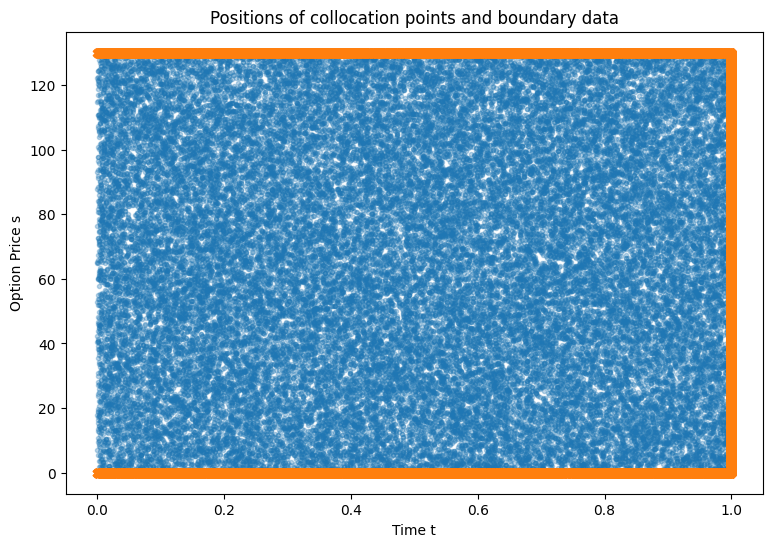

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter([sublist[0] for sublist in n_st_train], [sublist[1] for sublist in n_st_train], marker='.',alpha=0.3)
plt.scatter([sublist[0] for sublist in bc_st_train], [sublist[1] for sublist in bc_st_train], marker='X')
plt.xlabel('Time t')
plt.ylabel('Option Price s')

plt.title('Positions of collocation points and boundary data');

# Build Neural Network

The Neural Network Model based on https://arxiv.org/abs/1708.07469?context=q-fin.MF

In [8]:
import networks

DGMCell = networks.DGMCell(2, 100, 1, 3)
DGMCell.cuda()

DGMCell(
  (sig_act): Tanh()
  (Sw): Linear(in_features=2, out_features=100, bias=True)
  (Uz): Linear(in_features=2, out_features=100, bias=True)
  (Wsz): Linear(in_features=100, out_features=100, bias=True)
  (Ug): Linear(in_features=2, out_features=100, bias=True)
  (Wsg): Linear(in_features=100, out_features=100, bias=True)
  (Ur): Linear(in_features=2, out_features=100, bias=True)
  (Wsr): Linear(in_features=100, out_features=100, bias=True)
  (Uh): Linear(in_features=2, out_features=100, bias=True)
  (Wsh): Linear(in_features=100, out_features=100, bias=True)
  (Wf): Linear(in_features=100, out_features=1, bias=True)
)

In [9]:
fnn = networks.FeedforwardNeuralNetwork(2, 50, 1, 3)
fnn.cuda()

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [10]:
IFNN = networks.ImprovedFNN(2, 50, 1, 3)
IFNN.cuda()

ImprovedFNN(
  (input): Linear(in_features=2, out_features=50, bias=True)
  (hidden): ModuleList(
    (0-1): 2 x AdaptiveRelu()
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
)

In [11]:
n_epochs = 60000
lossFunction = nn.MSELoss()
optimizer = optim.Adam(IFNN.parameters(), lr=3e-5)

# Modelling

- For each iteration in the training loop, we are sampling data for the three physical conditions of the PDE.
- Then we are calculating the loss three times on the same model, accumulating them into a combined objective function to be minimised for the Neural Network.
- The first loss is the differential equation loss. Here we are trying to minimise the PDE by calculating gradients and forming the PDE itself.
- The remaining losses are calculated for boundary value and initial value conditions for the PDE.
- Mean Squared Error loss function `nn.MSELoss()` is chosen as the criterion to be minimised and 
- Adam optimizer `nn.optim.Adam(lr=3e-5)` with a learning rate of 0.00003 is chosen for performing the weight updates.

In [12]:
def reg_term(slopes):
    mean_slopes = slopes.mean()
    return torch.exp(mean_slopes).sum()

In [13]:
loss_hist = []
start_time = time.time()

for epoch in range(n_epochs):
    
    all_st_train, bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, 
                       r, 
                       sigma, 
                       T, 
                       S_range[-1], 
                       S_range, 
                       t_range, 
                       gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    # save training data points to tensor and send to device
    all_st_train = torch.from_numpy(all_st_train).float().to(device) 
    
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)
    
    
    # PDE Round
    y1_hat = IFNN(n_st_train)
    
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                       retain_graph=True, create_graph=True, only_inputs=True)[0]
    # print(grads)
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                          create_graph=True, only_inputs=True, allow_unused=True)[0]
    # print(grads2nd)
    if grads2nd is None:
        d2VdS2 = 0.0
    else:
        d2VdS2 = grads2nd[:, 1].view(-1, 1)
        print("not None: ", d2VdS2)
    S1 = n_st_train[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    
    # BC Round
    y21_hat = IFNN(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y21_hat)
    
    # slope recovery term = 1 / the mean of exp(the sum of the slope of the activation function a on layer L / the number of neurons on layer L) of all layers
    # Regularization term for each layer
    reg_loss = 0
    for layer in IFNN.hidden:
        slopes = layer.slopes
        reg_loss += reg_term(slopes)
        pass
    reg_loss = len(IFNN.hidden) / reg_loss
    
    
    # Backpropagation and Update
    optimizer.zero_grad()
    total_loss = pde_loss.mean() + bc_loss.mean()
    combined_loss = pde_loss.mean() + bc_loss.mean() + reg_loss
    combined_loss.backward()
    optimizer.step()
    
    loss_hist.append(combined_loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, reg_loss: {reg_loss.item(): 5f}, total loss: {total_loss.item():5f}')

end_time = time.time()
print('run time:', end_time - start_time)

TypeError: unsupported operand type(s) for *: 'ReLU' and 'Parameter'